# Discriminant functions in 1D

## Author: Dr Franck P. Vidal, Bangor University

For this Notebook, we will consider the features (*n*) individually to generate discriminant functions in one dimension. It is related to Lectre 4 on *Classification regions and discriminant functions*. Before you carry on, make sure you read and understand the slides.

A **discriminant function** takes the feature values for an object and outputs a value that is used to determine the class label of the object.

In [1]:
import math
import random
import numpy as np
import pandas as pd

from scipy.stats import kurtosis
from scipy.stats import skew

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 7.5
       }
matplotlib.rc('font', **font)

import SimpleITK as sitk # Load the medical DICOM file

from utils import *

# Load the dataset using Pandas

In [2]:
raw_df = pd.read_csv("dataset.csv")

In [3]:
df = raw_df.drop(labels=["x", "y", "length of tile size [in px]"], axis=1)

In [4]:
display(df)

,avg,median,stddev,kurtosis,skewness,c
0,0.351310,0.350828,0.018950,-0.477596,0.016406,2
1,0.315120,0.315080,0.018807,-0.572361,0.091526,2
2,1.460836,1.439744,0.189482,-1.206975,0.213772,2
3,0.411507,0.412270,0.018335,-0.520053,-0.037214,2
4,0.692839,2.289596,3.404967,-1.546484,-0.546712,1
5,-0.424341,-0.474168,0.489323,-1.062667,0.306800,1
6,-0.627581,-1.024072,0.611619,-0.554643,0.948299,2
7,0.503006,0.502757,0.017954,-0.528245,0.153976,2
8,1.432037,1.423266,0.183619,-1.249475,0.096541,2
9,0.355340,0.355296,0.018045,-0.404906,0.039975,1


# Extract the number of features

In [5]:
n = getn(df)
print("Number of features:", n)

Number of features: 5


# Extract the number of objects

In [6]:
N = getN(df)
print("Number of features:", N)

Number of features: 22


# Extract the labels

In [7]:
y = df["c"]

# Extract the feature names

In [8]:
# Get the label of all the columns, and remove the last one
dimensions=np.array(df.columns)[:-1]
print(dimensions)

['avg' 'median' 'stddev' 'kurtosis' 'skewness']


# Display the scatterplot matrix of features

## Using Matplotlib

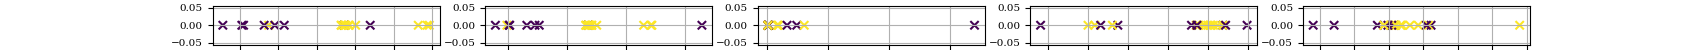

In [9]:
%matplotlib widget
plt.figure(figsize=(17, 0.5))

for i in range(n):
    plot_index = i + 1
    plt.subplot(1, n, plot_index)
    plt.scatter(df[dimensions[i]], np.zeros(N), marker="x", c=y)

    plt.xlabel(dimensions[i])

    plt.grid()

# In 1D

Write the discriminant function, e.g. 

$$g(\mathbf{x}) = x - a$$

Then select which column we are going to use. We must choose the ones that separate the two classes.

If the sign of $g(x)$ is negative, then the object is of a given class, else of the other class.

In [10]:
def g1(a, x):
    # Discriminant function
    g = x - a
    
    # Get the sign
    p = np.sign(g).astype(np.int8)
    
    # Foreground
    # Replace 1 with 2
    p[p==1] = 2
    
    # Background
    # Replace -1 with 1
    p[p==-1] = 1
        
    # Return the prediction
    return p 

In [11]:
x_avg = df["avg"]
x_median = df["median"]

for c, p_avg, p_median in zip(y, g1(-0.06, x_avg), g1(-0.04, x_median)):
    print(c, p_avg, p_median)

2 2 2
2 2 2
2 2 2
2 2 2
1 2 2
1 1 1
2 1 1
2 2 2
2 2 2
1 2 2
2 2 2
1 1 1
2 2 2
2 2 2
2 2 2
2 2 2
1 1 1
1 1 1
2 2 2
1 1 1
1 1 1
2 2 2


# Test our classifiers

## Load the image

In [12]:
np_image, bias, gain, vmin, vmax = loadImage()

# Extract random pixel positions

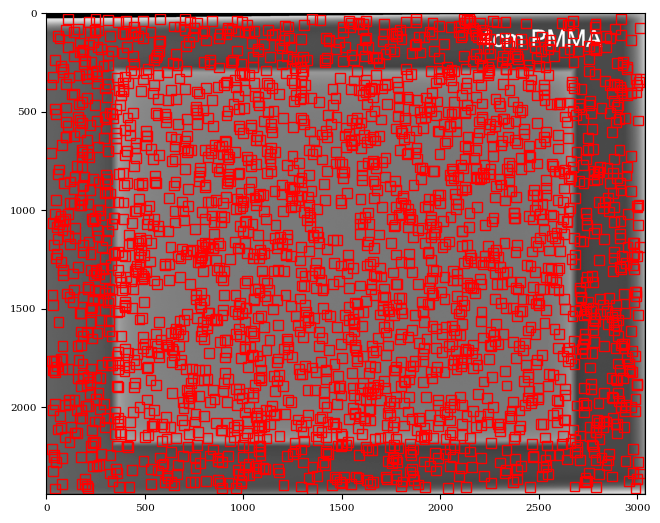

In [13]:
%matplotlib inline
tile_lenght = int(raw_df["length of tile size [in px]"].median())

plt.figure(figsize=(17,10))
ax = plt.subplot(1, 2, 1)
plt.imshow(np_image, cmap="gray", vmin=vmin, vmax=vmax)

pos_x = []
pos_y = []

for i in range(2500):
    
    pos_x.append(random.randint(0, np_image.shape[1] - 1 - tile_lenght))
    pos_y.append(random.randint(0, np_image.shape[0] - 1 - tile_lenght))

    rect = patches.Rectangle((pos_x[-1], pos_y[-1]), 
                         tile_lenght, tile_lenght, 
                         linewidth=1, edgecolor='r', facecolor='none');
    ax.add_patch(rect)


# Extract the corresponding features

In [14]:
def getRecord(x, y, image, tile_lenght):
    
    tile = image[y:y+tile_lenght, x:x+tile_lenght];

    row = []
    
    row.append(np.mean(tile))
    row.append(np.median(tile))
    row.append(np.std(tile))
    row.append(kurtosis(tile, axis=None))
    row.append(skew(tile, axis=None))
    
    return row

In [15]:
rows = []
for i, j in zip(pos_x, pos_y):
    rows.append(getRecord(i,j,np_image,tile_lenght))

In [16]:
test_df = pd.DataFrame(columns=dimensions, data=rows)

In [17]:
display(test_df)

,avg,median,stddev,kurtosis,skewness
0,1.247838,1.573240,0.892952,-1.054119,-0.627865
1,-0.568210,-0.569123,0.022710,-0.364417,0.206543
2,0.662360,-1.254479,3.167194,-1.329232,0.638554
3,0.437287,0.436846,0.018989,-0.301483,0.043491
4,-1.161170,-1.156730,0.026157,0.033276,-0.708021
...,...,...,...,...,...
2495,0.986244,0.968597,0.158230,-1.071135,0.265123
2496,0.391703,0.391603,0.019952,-0.513564,-0.014552
2497,-1.451449,-1.449975,0.053664,-1.387707,0.044046
2498,-1.405332,-1.405849,0.017533,-0.360650,0.094811


# Prediction using the discriminant function on $x_1$

In [18]:
prediction = g1(-0.06, test_df["avg"])

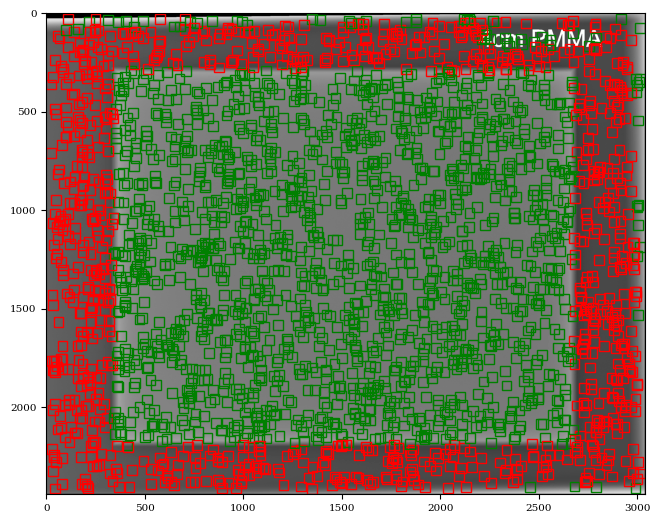

In [19]:
plt.figure(figsize=(17,10))
ax = plt.subplot(1, 2, 1)
plt.imshow(np_image, cmap="gray", vmin=vmin, vmax=vmax)

for i,j,c in zip(pos_x, pos_y, prediction):
    
    pos_x.append(random.randint(0, np_image.shape[1] - 1 - tile_lenght))
    pos_y.append(random.randint(0, np_image.shape[0] - 1 - tile_lenght))

    if c == 1:
        rect = patches.Rectangle((i, j), 
                             tile_lenght, tile_lenght, 
                             linewidth=1, edgecolor='r', facecolor='none');
    else:
        rect = patches.Rectangle((i, j), 
                             tile_lenght, tile_lenght, 
                             linewidth=1, edgecolor='g', facecolor='none');
    ax.add_patch(rect)

    

# Prediction using the discriminant function on $x_2$

In [20]:
prediction = g1(-0.04, test_df["median"])

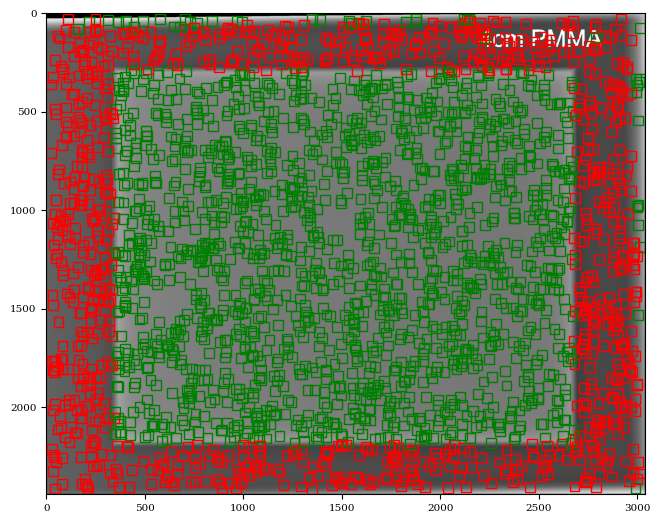

In [21]:
plt.figure(figsize=(17,10))
ax = plt.subplot(1, 2, 1)
plt.imshow(np_image, cmap="gray", vmin=vmin, vmax=vmax)

for i,j,c in zip(pos_x, pos_y, prediction):
    
    pos_x.append(random.randint(0, np_image.shape[1] - 1 - tile_lenght))
    pos_y.append(random.randint(0, np_image.shape[0] - 1 - tile_lenght))

    if c == 1:
        rect = patches.Rectangle((i, j), 
                             tile_lenght, tile_lenght, 
                             linewidth=1, edgecolor='r', facecolor='none');
    else:
        rect = patches.Rectangle((i, j), 
                             tile_lenght, tile_lenght, 
                             linewidth=1, edgecolor='g', facecolor='none');
    ax.add_patch(rect)

    

# Prediction using the discriminant function on $x_3$

In [22]:
prediction = g1(0.3, test_df["stddev"])

In [ ]:
plt.figure(figsize=(17,10))
ax = plt.subplot(1, 2, 1)
plt.imshow(np_image, cmap="gray", vmin=vmin, vmax=vmax)

for i,j,c in zip(pos_x, pos_y, prediction):
    
    pos_x.append(random.randint(0, np_image.shape[1] - 1 - tile_lenght))
    pos_y.append(random.randint(0, np_image.shape[0] - 1 - tile_lenght))

    if c == 1:
        rect = patches.Rectangle((i, j), 
                             tile_lenght, tile_lenght, 
                             linewidth=1, edgecolor='r', facecolor='none');
    else:
        rect = patches.Rectangle((i, j), 
                             tile_lenght, tile_lenght, 
                             linewidth=1, edgecolor='g', facecolor='none');
    ax.add_patch(rect)

    